In [1]:
'''
Data Source:
台北捷運 > 關於我們 > 統計資料 > 旅運量  > 各站進出量統計  
Url: https://www.metro.taipei/cp.aspx?n=FF31501BEBDD0136  

Requirement:
1. Open topic, browsing data to determine what question you'd like to answer, can be time series related (multiple months) or time-independent (single month)
2. Develop in python, no module restrictions
3. Open for any external source for EDA, but need to attach
4. Must have: creating new features from existing statistics
5. Please deliver before 9/2 (Mon) COB

Delivery:
1. Jupyter notebook (.ipynb) file contains
    * Data loading from data source
    * EDA processes
    * Result Plotting
2. Slides (no more than 3 pages) contains
    * Objective
    * Result
'''
from pyexcel_ods import get_data
import os
import urllib.request
from bs4 import BeautifulSoup
import pandas as pd
import plotly.graph_objects as go
import random


In [2]:
# 創資料夾放資料
sfData = '../data/'
sfDailyinout = '../data/dailyinout/'
sfHourlyinout = '../data/hourlyinout/'
def CreateFolder(sfolder):
    if not os.path.exists(sfolder):
        os.makedirs(sfolder)
CreateFolder(sfData)
CreateFolder(sfDailyinout)
CreateFolder(sfHourlyinout)

In [32]:
# 抓網頁內容 from url
httpRsp = urllib.request.urlopen('https://www.metro.taipei/cp.aspx?n=FF31501BEBDD0136')
sRsp = httpRsp.read().decode('utf8')
httpRsp.close()

## 以 Beautiful Soup 解析 HTML 程式碼
soup = BeautifulSoup(sRsp, 'html.parser')
tagUrl = soup.find(attrs={'class': 'area-editor user-edit'}).find('table').find_all('a')
lstUrl = [sUrl.get('href') for sUrl in tagUrl ]

## 下載檔案
for sUrl in lstUrl:
    urllib.request.urlretrieve(sUrl, sfDailyinout + sUrl.split('/')[-1])

KeyboardInterrupt: 

In [3]:
# 讀檔
lstFile = os.listdir(sfDailyinout)
dfDatain = pd.DataFrame()
dfDataout = pd.DataFrame()
def ReadData(sFile):
    data = get_data(sFile)
    # in data
    dfin = data['進站資料']
    dfin = list(filter(lambda x: len(x)==len(dfin[0]), dfin))
    dfin = pd.DataFrame(dfin[1:], columns=dfin[0])
    dfin.rename(columns={dfin.columns[0]:'Date', '臺大醫院':'台大醫院', '台北101/世貿中心': '台北101/世貿'}, inplace=True)
    # out data
    dfout = data['出站資料']
    dfout = list(filter(lambda x: len(x)==len(dfout[0]), dfout))
    dfout = pd.DataFrame(dfout[1:], columns=dfout[0])
    dfout.rename(columns={dfout.columns[0]:'Date', '臺大醫院':'台大醫院', '台北101/世貿中心': '台北101/世貿'}, inplace=True)
    return dfin, dfout

for sFile in lstFile:
    dfTempin, dfTempout = ReadData(sfDailyinout + sFile)
    dfDatain = dfDatain.append(dfTempin)
    dfDataout = dfDataout.append(dfTempout)

In [8]:
# Sample 站點畫 time series
iNplot = 5
#lstPlotcolor = ['firebrick', 'deepskyblue', 'royalblue']
lstPlotcolor = ['rgb(' +  str(random.randrange(256)) + ', ' + str(random.randrange(256)) + ', ' + str(random.randrange(256)) + ')' for i in range(iNplot)]
lstPlotstation = random.sample(list(dfDatain.columns[1:]),k=iNplot)
def PlotNTimeSeries(iNplot, lstColor, lstPlotstation):
    fig = go.Figure()
    for i in range(iNplot):
        sStation = lstPlotstation[i]
        fig.add_trace(go.Scatter(x=dfDatain.Date, y=dfDatain[sStation], name=sStation + '_In', 
                                 line=dict(color=lstPlotcolor[i], width=2)))
        fig.add_trace(go.Scatter(x=dfDataout.Date, y=dfDataout[sStation], name=sStation + '_Out', 
                                 line = dict(color=lstPlotcolor[i], width=2, dash='dot')))

    fig.update_layout(title_text='MRT Station Time Series Plot',
                      xaxis_rangeslider_visible=True)
    fig.show()

PlotNTimeSeries(iNplot, lstPlotcolor, lstPlotstation)   


In [7]:
print(dfDatain.shape)
print(dfDataout.shape)

from collections import Counter
import numpy as np
Counter(dfDataout.columns)

dfStation = pd.DataFrame({'Station': dfDatain.columns[1:]})
dfStation
dfDatain['Weekday'] = dfDatain['Date'].dt.dayofweek+1
dict_aggregations = {}
for col in dfStation['Station']:
    dict_aggregations[col] = ['mean'] #['min', 'max', 'mean', 'size']
    
dfDatain_agg = dfDatain.groupby('Weekday').agg(dict_aggregations)
dfDatain_agg

(212, 109)
(212, 109)


,松山機場,中山國中,南京復興,忠孝復興,大安,科技大樓,六張犁,麟光,辛亥,萬芳醫院,...,中山國小,行天宮,東門,蘆洲,三民高中,徐匯中學,三和國中,三重國小,迴龍,丹鳳
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,...,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
Weekday,,,,,,,,,,,,,,,,,,,,,
1,5919.900000,15268.133333,40612.200000,43936.366667,26207.600000,15138.133333,11930.033333,4338.766667,3208.066667,13947.066667,...,17940.733333,29224.466667,24495.033333,14609.733333,12210.300000,12060.800000,12880.400000,11879.200000,10456.633333,9750.333333
2,5873.580645,15561.516129,40984.741935,45910.806452,26703.032258,15387.580645,12094.032258,4433.677419,3300.838710,14145.451613,...,18058.129032,30305.322581,25427.548387,14584.612903,12303.032258,12190.903226,12889.064516,12045.741935,10456.064516,9819.870968
3,5982.032258,15830.451613,41437.935484,47563.322581,27036.774194,15758.548387,12301.774194,4551.838710,3357.290323,14447.677419,...,18308.258065,30183.354839,26102.741935,14887.483871,12592.354839,12474.709677,13162.258065,12279.354839,10690.225806,10017.419355
4,5893.833333,15659.333333,41063.966667,48249.133333,26703.900000,15500.300000,12224.966667,4555.366667,3344.600000,13990.566667,...,18144.133333,29698.166667,25952.366667,14691.000000,12405.300000,12328.633333,12973.566667,12121.700000,10540.966667,9895.166667
5,6580.966667,15988.233333,41258.966667,52870.333333,27000.100000,15844.700000,12495.400000,4749.766667,3387.366667,15071.666667,...,18556.466667,30472.266667,27649.300000,15194.066667,12895.566667,12937.733333,13379.533333,12595.300000,10953.600000,10385.700000
6,5131.300000,11342.533333,26107.200000,52787.933333,18702.500000,11710.266667,9327.633333,4315.466667,2725.000000,10524.700000,...,14614.766667,22663.666667,25667.333333,12634.333333,10982.600000,11356.000000,10980.633333,11100.500000,8702.266667,8808.500000
7,5120.866667,8851.800000,19833.533333,42588.333333,14173.566667,9380.500000,7261.366667,3816.833333,2264.933333,7644.366667,...,12079.466667,18470.333333,21843.300000,10211.900000,8927.900000,9211.266667,8995.333333,9302.600000,7199.700000,7193.466667


C:\Users\chingyu\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


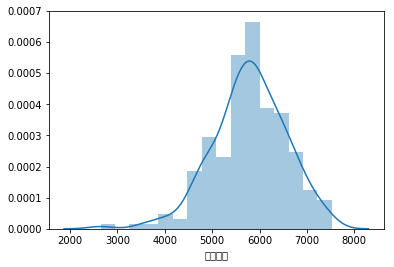

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(dfDatain['松山機場']);

In [ ]:
# 正規化

In [6]:
import plotly.graph_objects as go

import pandas as pd

# Load dataset
df = pd.read_csv(
    "https://raw.githubusercontent.com/plotly/datasets/master/finance-charts-apple.csv")
df.columns = [col.replace("AAPL.", "") for col in df.columns]

# Initialize figure
fig = go.Figure()

# Add Traces

fig.add_trace(
    go.Scatter(x=list(df.index),
               y=list(df.High),
               name="High",
               line=dict(color="#33CFA5")))

fig.add_trace(
    go.Scatter(x=list(df.index),
               y=[df.High.mean()] * len(df.index),
               name="High Average",
               visible=False,
               line=dict(color="#33CFA5", dash="dash")))

fig.add_trace(
    go.Scatter(x=list(df.index),
               y=list(df.Low),
               name="Low",
               line=dict(color="#F06A6A")))

fig.add_trace(
    go.Scatter(x=list(df.index),
               y=[df.Low.mean()] * len(df.index),
               name="Low Average",
               visible=False,
               line=dict(color="#F06A6A", dash="dash")))

# Add Annotations and Buttons
high_annotations = [dict(x="2016-03-01",
                         y=df.High.mean(),
                         xref="x", yref="y",
                         text="High Average:<br> %.3f" % df.High.mean(),
                         ax=0, ay=-40),
                    dict(x=df.High.idxmax(),
                         y=df.High.max(),
                         xref="x", yref="y",
                         text="High Max:<br> %.3f" % df.High.max(),
                         ax=0, ay=-40)]
low_annotations = [dict(x="2015-05-01",
                        y=df.Low.mean(),
                        xref="x", yref="y",
                        text="Low Average:<br> %.3f" % df.Low.mean(),
                        ax=0, ay=40),
                   dict(x=df.High.idxmin(),
                        y=df.Low.min(),
                        xref="x", yref="y",
                        text="Low Min:<br> %.3f" % df.Low.min(),
                        ax=0, ay=40)]

fig.update_layout(
    updatemenus=[
        go.layout.Updatemenu(
            active=0,
            buttons=list([
                dict(label="None",
                     method="update",
                     args=[{"visible": [True, False, True, False]},
                           {"title": "Yahoo",
                            "annotations": []}]),
                dict(label="High",
                     method="update",
                     args=[{"visible": [True, True, False, False]},
                           {"title": "Yahoo High",
                            "annotations": high_annotations}]),
                dict(label="Low",
                     method="update",
                     args=[{"visible": [False, False, True, True]},
                           {"title": "Yahoo Low",
                            "annotations": low_annotations}]),
                dict(label="Both",
                     method="update",
                     args=[{"visible": [True, True, True, True]},
                           {"title": "Yahoo",
                            "annotations": high_annotations + low_annotations}]),
            ]),
        )
    ])

# Set title
fig.update_layout(title_text="Yahoo")

fig.show()